In [1]:
%automagic


Automagic is OFF, % prefix IS needed for line magics.


In [2]:
folder = '/home/dsc/Repos/TFM_Accident_reduction_plan_in_the_city_of_Madrid/02_Desarrollo'
!ls -ltr {folder}

total 39692
-rw-rw-r-- 1 dsc dsc     1695 oct 19 16:58 00_work_line_notes.txt
-rw-rw-r-- 1 dsc dsc   309961 oct 20 11:55 01_ciclo_prueba_muestra.ipynb
-rw-rw-r-- 1 dsc dsc   337332 oct 23 16:39 02_ciclo_prueba_muestra_ordenado.ipynb
drwxrwxr-x 2 dsc dsc     4096 oct 23 16:56 csv_files
-rw-rw-r-- 1 dsc dsc    26352 oct 29 18:05 residuo.png
-rw-rw-r-- 1 dsc dsc    28090 oct 29 18:05 estacionalidad.png
-rw-rw-r-- 1 dsc dsc    16061 oct 29 18:05 tendencia.png
-rw-rw-r-- 1 dsc dsc    36481 oct 29 18:06 todo.png
-rw-rw-r-- 1 dsc dsc    28121 oct 29 18:37 residuo_nube.png
-rw-rw-r-- 1 dsc dsc    16512 oct 29 18:38 estacionalidad_nube.png
-rw-rw-r-- 1 dsc dsc    28910 oct 29 18:38 tendencia_nube.png
-rw-rw-r-- 1 dsc dsc    48129 oct 29 18:38 todo_nube.png
-rw-rw-r-- 1 dsc dsc  2403149 nov  3 18:08 04_ciclo_prueba_muestra_serie_temporal_lio.ipynb
-rw-rw-r-- 1 dsc dsc  1919420 nov  9 12:25 04_ciclo_prueba_muestra_serie_temporal.ipynb
-rw-rw-r-- 1 dsc dsc  1741628 nov 16 17:12 serie_completa.csv


In [3]:
import os
os.getcwd()

'/home/dsc/Repos/TFM_Accident_reduction_plan_in_the_city_of_Madrid/02_Desarrollo'

In [4]:
os.chdir(folder)
os.getcwd()

'/home/dsc/Repos/TFM_Accident_reduction_plan_in_the_city_of_Madrid/02_Desarrollo'

In [5]:
!ls -ltr datos_accs_madrid.csv

-rw-rw-r-- 1 dsc dsc 24017454 nov 16 18:37 datos_accs_madrid.csv


In [6]:
import pandas as pd
df_accs = pd.read_csv("datos_accs_madrid.csv")

In [7]:
# Imports needed for the script
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
#plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from IPython.display import Image as PImage
from subprocess import check_call
from PIL import Image, ImageDraw, ImageFont

In [8]:
# Análisis Exploratorio Inicial
# Ahora veamos cuantas columnas y registros tenemos:
df_accs.shape

(252998, 11)

In [9]:
df_accs.head(3)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERSONAS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX
0,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,20
1,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,50
2,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,VIAJERO,MUJER,HERIDO_LEVE,40


In [10]:
# Dejamos y tratamos la columna NUM_PERSONAS (nº personas implicadas), puesto que nos puede
# servir de pesos en valor acumulado

In [11]:
df_accs["NUM_PERSONAS"].unique()

array([ 1,  7,  2,  3,  4,  5,  9,  6,  8, 18, 13, 11, 22, 10, 14, 12, 16,
       19, 15])

In [12]:
df_accs = df_accs.rename(columns = {'NUM_PERSONAS':'NUM_PERS_IMPLS'})
df_accs.head()

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX
0,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,20
1,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,50
2,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,VIAJERO,MUJER,HERIDO_LEVE,40
3,01/01/2010,01:00,VIERNES,PUENTE DE VALLECAS,7,COLISION_MULTIPLE,NO_ASIGNADO,VIAJERO,MUJER,HERIDO_LEVE,25
4,01/01/2010,01:00,VIERNES,PUENTE DE VALLECAS,7,COLISION_MULTIPLE,NO_ASIGNADO,VIAJERO,MUJER,HERIDO_LEVE,30


In [13]:
df_accs.dtypes

FECHA             object
HORA              object
DIA_SEMANA        object
DISTRITO          object
NUM_PERS_IMPLS     int64
TIPO_ACCIDENTE    object
TIPO_VEHICULO     object
TIPO_PERSONA      object
SEXO              object
LESIVIDAD         object
EDAD_APROX        object
dtype: object

In [14]:
df_accs["NUM_PERS_IMPLS"] = df_accs["NUM_PERS_IMPLS"].replace({0:'NO_ASIGNADO'}, regex=True)

In [15]:
df_accs["NUM_PERS_IMPLS"].unique()

array([ 1,  7,  2,  3,  4,  5,  9,  6,  8, 18, 13, 11, 22, 10, 14, 12, 16,
       19, 15])

In [16]:
# algunas visualizaciones para comprender mejor nuestros datos.
# Mirar balanceo de etiquetas

In [17]:
df_accs.groupby('DIA_SEMANA').size()

DIA_SEMANA
DOMINGO      27249
JUEVES       38794
LUNES        36301
MARTES       37707
MIERCOLES    38697
SABADO       30798
VIERNES      43452
dtype: int64

In [18]:
df_accs.groupby('DISTRITO').size()

DISTRITO
ARGANZUELA             13050
BARAJAS                 3402
CARABANCHEL            15593
CENTRO                 17717
CHAMARTIN              18857
CHAMBERI               14466
CIUDAD LINEAL          16580
FUENCARRAL-EL PARDO    13750
HORTALEZA               8546
LATINA                 12218
MONCLOA-ARAVACA        13587
MORATALAZ               6246
PUENTE DE VALLECAS     16180
RETIRO                 13665
SALAMANCA              19269
SAN BLAS               11987
TETUAN                 13626
USERA                   8808
VICALVARO               3142
VILLA DE VALLECAS       5601
VILLAVERDE              6708
dtype: int64

In [19]:
df_accs.groupby('TIPO_ACCIDENTE').size()

TIPO_ACCIDENTE
ATROPELLO                     41398
CAIDA_BICICLETA                2616
CAIDA_CICLOMOTOR               2536
CAIDA_MOTOCICLETA             14155
CAIDA_VEHICULO_ 3_ RUEDAS        19
CAIDA_VIAJERO_ BUS             2794
CHOQUE_CON_OBJETO_FIJO        12595
COLISION_DOBLE               145544
COLISION_MULTIPLE             29195
OTRAS_CAUSAS                   1011
VUELCO                         1135
dtype: int64

In [20]:
df_accs.groupby('TIPO_VEHICULO').size()

TIPO_VEHICULO
AMBULANCIA            492
AUTOBUS_AUTOCAR      7017
AUTO_TAXI            8311
BICICLETA            5524
CAMION               2499
CICLOMOTOR           6045
FURGONETA            9873
MOTOCICLETA         32742
NO_ASIGNADO         46852
TURISMO            131483
VARIOS               2117
VEH.3 RUEDAS           43
dtype: int64

In [21]:
df_accs.groupby('TIPO_PERSONA').size()

TIPO_PERSONA
CONDUCTOR    158734
PEATON        15118
TESTIGO       31666
VIAJERO       47480
dtype: int64

In [22]:
df_accs.groupby('SEXO').size()

SEXO
HOMBRE         160165
MUJER           80717
NO_ASIGNADO     12116
dtype: int64

In [23]:
df_accs.groupby('LESIVIDAD').size()

LESIVIDAD
HERIDO_GRAVE      8850
HERIDO_LEVE     102716
INGRESO_LEVE    130053
MUERTO             275
NO_ASIGNADO      11104
dtype: int64

In [24]:
df_accs.groupby('EDAD_APROX').size()

EDAD_APROX
0               3128
10              5124
15              2593
20              9304
25             49329
30             31110
35             30169
40             26421
45             22167
50             17999
55             12454
65             13459
70              3656
75              6361
NO_ASIGNADO    19724
dtype: int64

In [25]:
df_accs.groupby('NUM_PERS_IMPLS').size()

NUM_PERS_IMPLS
1     183618
2      43631
3      14168
4       6165
5       2712
6       1116
7        755
8        270
9        139
10       120
11        56
12        28
13        46
14        33
15        17
16        19
18        41
19        42
22        22
dtype: int64

In [26]:
# Comprobar valores nulos
df_accs.isnull().sum()

FECHA             0
HORA              0
DIA_SEMANA        0
DISTRITO          0
NUM_PERS_IMPLS    0
TIPO_ACCIDENTE    0
TIPO_VEHICULO     0
TIPO_PERSONA      0
SEXO              0
LESIVIDAD         0
EDAD_APROX        0
dtype: int64

In [27]:
# Veamos cuántos registros hay según DIA_SEMANA:

In [28]:
df_accs.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX'],
      dtype='object')

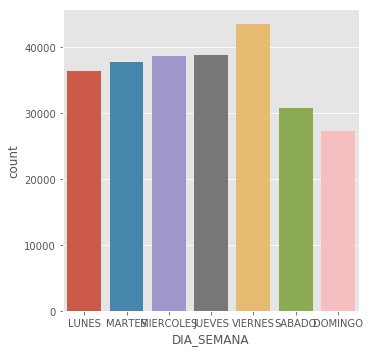

In [29]:
#figure(figsize=(5,5))
sb.catplot('DIA_SEMANA',data=df_accs,kind="count", \
           order=["LUNES", "MARTES", "MIERCOLES", "JUEVES", "VIERNES", "SABADO", "DOMINGO"])

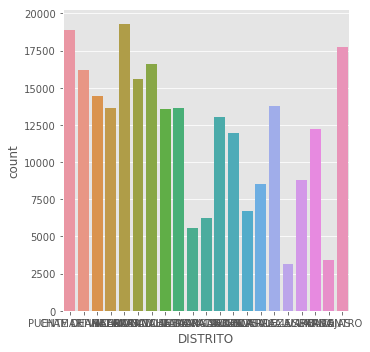

In [30]:
sb.catplot('DISTRITO',data=df_accs,kind="count")

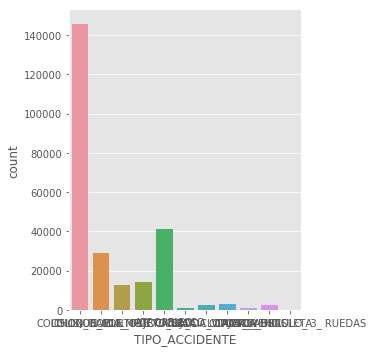

In [31]:
sb.catplot('TIPO_ACCIDENTE',data=df_accs,kind="count")

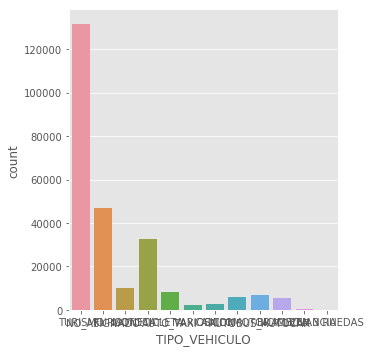

In [32]:
sb.catplot('TIPO_VEHICULO',data=df_accs,kind="count")

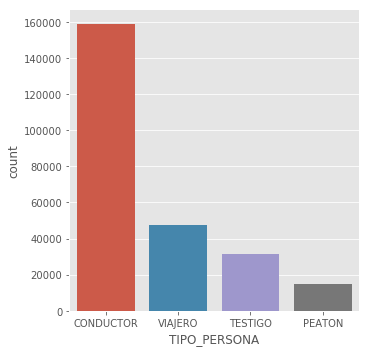

In [33]:
sb.catplot('TIPO_PERSONA',data=df_accs,kind="count")

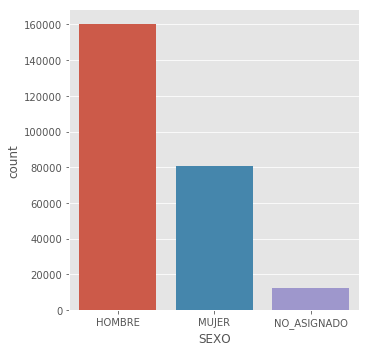

In [34]:
sb.catplot('SEXO',data=df_accs,kind="count")

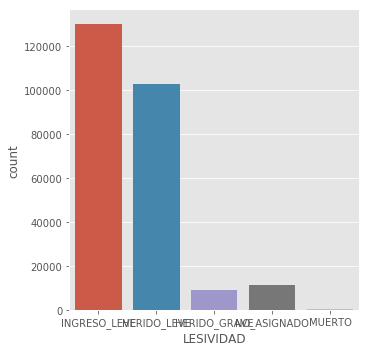

In [35]:
sb.catplot('LESIVIDAD',data=df_accs,kind="count")

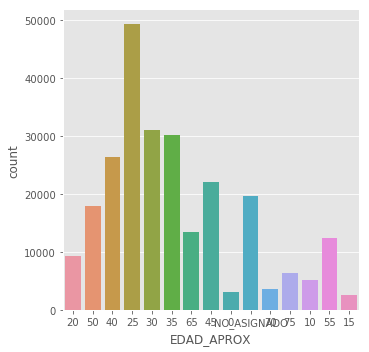

In [36]:
sb.catplot('EDAD_APROX',data=df_accs,kind="count")

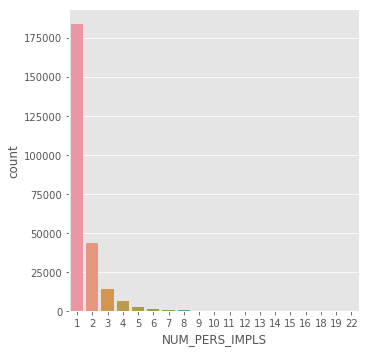

In [37]:
sb.catplot('NUM_PERS_IMPLS',data=df_accs,kind="count")

In [38]:
df_accs.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX'],
      dtype='object')

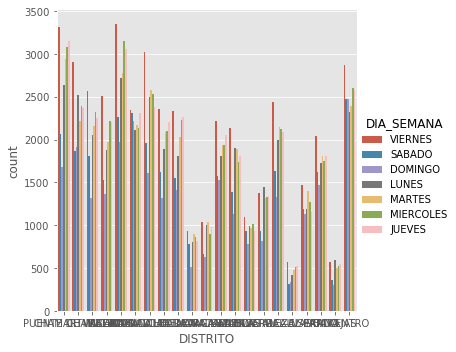

In [39]:
sb.catplot('DISTRITO',data=df_accs,hue='DIA_SEMANA',kind="count")

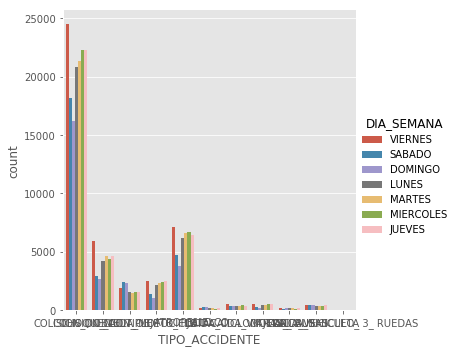

In [40]:
sb.catplot('TIPO_ACCIDENTE',data=df_accs,hue='DIA_SEMANA',kind="count")

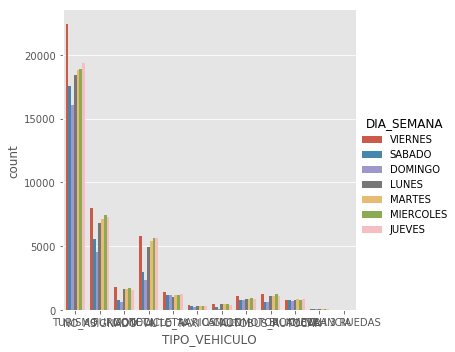

In [41]:
sb.catplot('TIPO_VEHICULO',data=df_accs,hue='DIA_SEMANA',kind="count")

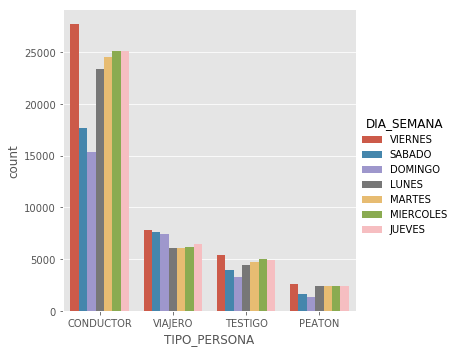

In [42]:
sb.catplot('TIPO_PERSONA',data=df_accs,hue='DIA_SEMANA',kind="count")

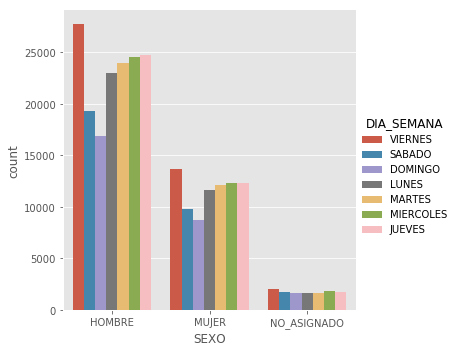

In [43]:
sb.catplot('SEXO',data=df_accs,hue='DIA_SEMANA',kind="count")

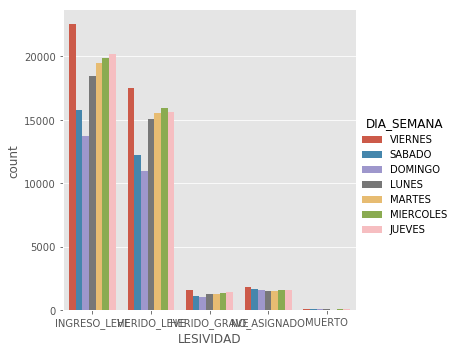

In [44]:
sb.catplot('LESIVIDAD',data=df_accs,hue='DIA_SEMANA',kind="count")

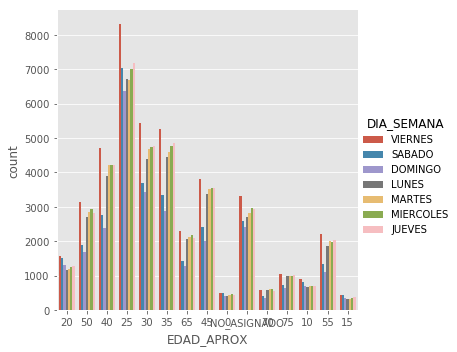

In [45]:
sb.catplot('EDAD_APROX',data=df_accs,hue='DIA_SEMANA',kind="count")

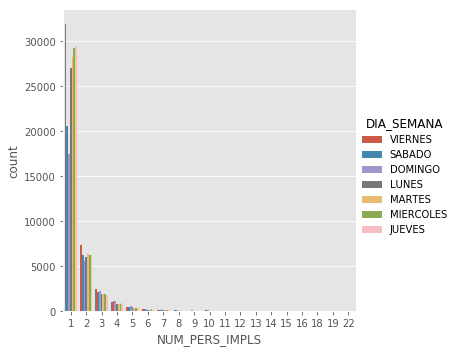

In [46]:
sb.catplot('NUM_PERS_IMPLS',data=df_accs,hue='DIA_SEMANA',kind="count")

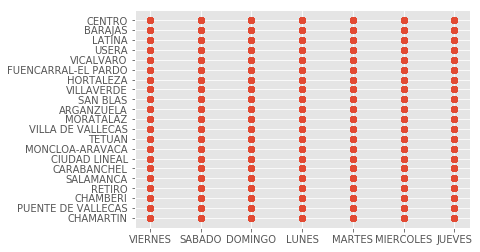

In [47]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['DISTRITO'].values)
plt.show()

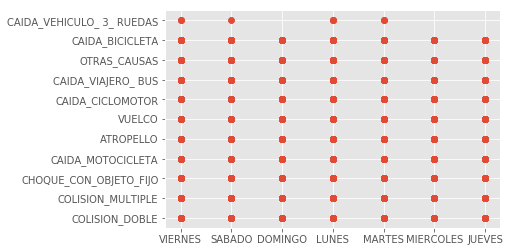

In [48]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['TIPO_ACCIDENTE'].values)
plt.show()

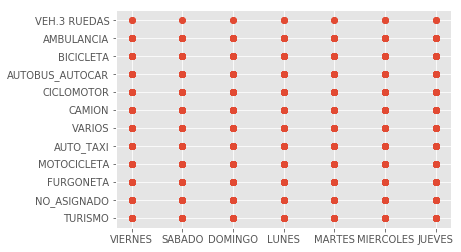

In [49]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['TIPO_VEHICULO'].values)
plt.show()

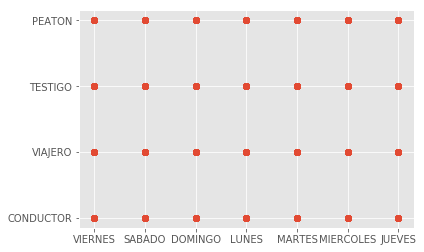

In [50]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['TIPO_PERSONA'].values)
plt.show()

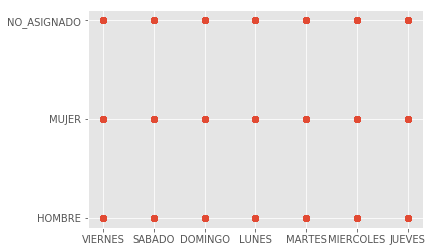

In [51]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['SEXO'].values)
plt.show()

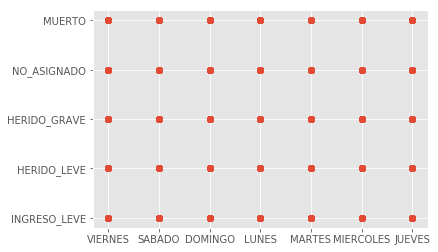

In [52]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['LESIVIDAD'].values)
plt.show()

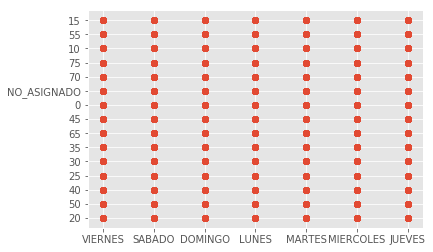

In [53]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['EDAD_APROX'].values)
plt.show()

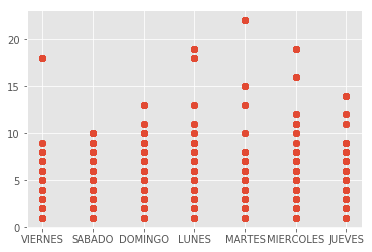

In [54]:
plt.scatter(df_accs['DIA_SEMANA'].values, df_accs['NUM_PERS_IMPLS'].values)
plt.show()

In [55]:
# Mapeo de datos

In [56]:
#Filtro: Columnas que empiezan por xxx
#filtro_borrar = [col for col in df_accs if col.startswith('NUM_PERS')]
# borrar columnas sobrantes:
#df_accs = df_accs.drop(columns=filtro_borrar)

In [57]:
df_accs_lab = df_accs.copy()

In [58]:
df_accs.head(1)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX
0,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,20


In [59]:
df_accs_lab.head(1)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX
0,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,20


In [60]:
df_accs.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX'],
      dtype='object')

In [61]:
df_accs_lab.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX'],
      dtype='object')

In [62]:
df_accs.dtypes

FECHA             object
HORA              object
DIA_SEMANA        object
DISTRITO          object
NUM_PERS_IMPLS     int64
TIPO_ACCIDENTE    object
TIPO_VEHICULO     object
TIPO_PERSONA      object
SEXO              object
LESIVIDAD         object
EDAD_APROX        object
dtype: object

In [63]:
df_accs_lab.dtypes

FECHA             object
HORA              object
DIA_SEMANA        object
DISTRITO          object
NUM_PERS_IMPLS     int64
TIPO_ACCIDENTE    object
TIPO_VEHICULO     object
TIPO_PERSONA      object
SEXO              object
LESIVIDAD         object
EDAD_APROX        object
dtype: object

In [64]:
# No haría falta: df_accs_lab["EDAD_APROX"]=df_accs_lab['EDAD_APROX'].astype(np.int64)

In [65]:
df_accs_lab.dtypes

FECHA             object
HORA              object
DIA_SEMANA        object
DISTRITO          object
NUM_PERS_IMPLS     int64
TIPO_ACCIDENTE    object
TIPO_VEHICULO     object
TIPO_PERSONA      object
SEXO              object
LESIVIDAD         object
EDAD_APROX        object
dtype: object

In [66]:
!ls -ltr {folder}/ditri*

ls: cannot access '/home/dsc/Repos/TFM_Accident_reduction_plan_in_the_city_of_Madrid/02_Desarrollo/ditri*': No such file or directory


In [67]:
import os
os.getcwd()

'/home/dsc/Repos/TFM_Accident_reduction_plan_in_the_city_of_Madrid/02_Desarrollo'

In [68]:
!ls -ltr distritos_municipio_madrid.csv

-rw-rw-r-- 1 dsc dsc 1164 nov 22 17:41 distritos_municipio_madrid.csv


In [69]:
df_distritos = pd.read_csv("distritos_municipio_madrid.csv", sep=';', encoding='latin-1')

In [70]:
df_distritos.columns

Index(['distrito_codigo', 'distrito_nombre', 'municipio_codigo',
       'municipio_nombre', 'superficie_km2', 'densidad_por_km2'],
      dtype='object')

In [71]:
df_distritos.head(3)

,distrito_codigo,distrito_nombre,municipio_codigo,municipio_nombre,superficie_km2,densidad_por_km2
0,79601,Centro,796,Madrid,5.21,25340.69
1,79602,Arganzuela,796,Madrid,6.52,23306.44
2,79603,Retiro,796,Madrid,5.42,21867.53


In [72]:
drop_elements = ['distrito_codigo', 'municipio_codigo', 'municipio_nombre']
df_distritos_lab = df_distritos.drop(drop_elements, axis = 1)

In [73]:
df_distritos_lab.columns

Index(['distrito_nombre', 'superficie_km2', 'densidad_por_km2'], dtype='object')

In [74]:
df_distritos_lab.head(3)

,distrito_nombre,superficie_km2,densidad_por_km2
0,Centro,5.21,25340.69
1,Arganzuela,6.52,23306.44
2,Retiro,5.42,21867.53


In [75]:
df_distritos_lab.dtypes

distrito_nombre      object
superficie_km2      float64
densidad_por_km2    float64
dtype: object

In [76]:
df_distritos_lab.shape

(21, 3)

In [77]:
df_accs.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX'],
      dtype='object')

In [78]:
df_distritos_lab = df_distritos_lab.rename(columns = {'distrito_nombre':'DISTRITO'})

In [79]:
df_distritos_lab.head()

,DISTRITO,superficie_km2,densidad_por_km2
0,Centro,5.21,25340.69
1,Arganzuela,6.52,23306.44
2,Retiro,5.42,21867.53
3,Salamanca,5.36,26830.78
4,Chamartín,9.12,15723.25


In [80]:
df_accs.head(3)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX
0,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,20
1,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,50
2,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,VIAJERO,MUJER,HERIDO_LEVE,40


In [81]:
df_accs['DISTRITO'].unique()

array(['CHAMARTIN', 'PUENTE DE VALLECAS', 'CHAMBERI', 'RETIRO',
       'SALAMANCA', 'CARABANCHEL', 'CIUDAD LINEAL', 'MONCLOA-ARAVACA',
       'TETUAN', 'VILLA DE VALLECAS', 'MORATALAZ', 'ARGANZUELA',
       'SAN BLAS', 'VILLAVERDE', 'HORTALEZA', 'FUENCARRAL-EL PARDO',
       'VICALVARO', 'USERA', 'LATINA', 'BARAJAS', 'CENTRO'], dtype=object)

In [82]:
df_distritos_lab['DISTRITO'].unique()

array(['    Centro ', '    Arganzuela ', '    Retiro ', '    Salamanca ',
       '    Chamartín ', '    Tetuan ', '    Chamberí ',
       '    Fuencarral-El Pardo ', '    Moncloa-Aravaca ', '    Latina ',
       '    Carabanchel ', '    Usera ', '    Puente de Vallecas ',
       '    Moratalaz ', '    Ciudad Lineal ', '    Hortaleza ',
       '    Villaverde ', '    Villa de Vallecas ', '    Vicálvaro ',
       '    San Blas-Canillejas ', '    Barajas '], dtype=object)

In [83]:
# strip leading and trailing space only strings
df_distritos_lab['DISTRITO'] = df_distritos_lab['DISTRITO'].str.strip()


In [84]:
df_distritos_lab['DISTRITO'].unique()

array(['Centro', 'Arganzuela', 'Retiro', 'Salamanca', 'Chamartín',
       'Tetuan', 'Chamberí', 'Fuencarral-El Pardo', 'Moncloa-Aravaca',
       'Latina', 'Carabanchel', 'Usera', 'Puente de Vallecas',
       'Moratalaz', 'Ciudad Lineal', 'Hortaleza', 'Villaverde',
       'Villa de Vallecas', 'Vicálvaro', 'San Blas-Canillejas', 'Barajas'],
      dtype=object)

In [85]:
df_accs['DISTRITO'].unique()

array(['CHAMARTIN', 'PUENTE DE VALLECAS', 'CHAMBERI', 'RETIRO',
       'SALAMANCA', 'CARABANCHEL', 'CIUDAD LINEAL', 'MONCLOA-ARAVACA',
       'TETUAN', 'VILLA DE VALLECAS', 'MORATALAZ', 'ARGANZUELA',
       'SAN BLAS', 'VILLAVERDE', 'HORTALEZA', 'FUENCARRAL-EL PARDO',
       'VICALVARO', 'USERA', 'LATINA', 'BARAJAS', 'CENTRO'], dtype=object)

In [86]:
df_distritos_lab['DISTRITO'] = df_distritos_lab['DISTRITO'].str.upper()

In [87]:
df_distritos_lab['DISTRITO'].unique()

array(['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTÍN',
       'TETUAN', 'CHAMBERÍ', 'FUENCARRAL-EL PARDO', 'MONCLOA-ARAVACA',
       'LATINA', 'CARABANCHEL', 'USERA', 'PUENTE DE VALLECAS',
       'MORATALAZ', 'CIUDAD LINEAL', 'HORTALEZA', 'VILLAVERDE',
       'VILLA DE VALLECAS', 'VICÁLVARO', 'SAN BLAS-CANILLEJAS', 'BARAJAS'],
      dtype=object)

In [88]:
df_accs['DISTRITO'].unique()

array(['CHAMARTIN', 'PUENTE DE VALLECAS', 'CHAMBERI', 'RETIRO',
       'SALAMANCA', 'CARABANCHEL', 'CIUDAD LINEAL', 'MONCLOA-ARAVACA',
       'TETUAN', 'VILLA DE VALLECAS', 'MORATALAZ', 'ARGANZUELA',
       'SAN BLAS', 'VILLAVERDE', 'HORTALEZA', 'FUENCARRAL-EL PARDO',
       'VICALVARO', 'USERA', 'LATINA', 'BARAJAS', 'CENTRO'], dtype=object)

In [89]:
df_distritos_lab["DISTRITO"] = df_distritos_lab["DISTRITO"].replace({"CHAMARTÍN":"CHAMARTIN"}, regex=True)
df_distritos_lab["DISTRITO"] = df_distritos_lab["DISTRITO"].replace({"CHAMBERÍ":"CHAMBERI"}, regex=True)
df_distritos_lab["DISTRITO"] = df_distritos_lab["DISTRITO"].replace({"VICÁLVARO":"VICALVARO"}, regex=True)
df_distritos_lab["DISTRITO"] = df_distritos_lab["DISTRITO"].replace({"SAN BLAS-CANILLEJAS":"SAN BLAS"}, regex=True)

In [90]:
df_distritos_lab['DISTRITO'].unique()

array(['CENTRO', 'ARGANZUELA', 'RETIRO', 'SALAMANCA', 'CHAMARTIN',
       'TETUAN', 'CHAMBERI', 'FUENCARRAL-EL PARDO', 'MONCLOA-ARAVACA',
       'LATINA', 'CARABANCHEL', 'USERA', 'PUENTE DE VALLECAS',
       'MORATALAZ', 'CIUDAD LINEAL', 'HORTALEZA', 'VILLAVERDE',
       'VILLA DE VALLECAS', 'VICALVARO', 'SAN BLAS', 'BARAJAS'],
      dtype=object)

In [91]:
from functools import reduce
df_accs_join_dist = [df_accs, df_distritos_lab]
df_accs_join_dist = reduce(lambda left,right: pd.merge(left,right, on=['DISTRITO']), df_accs_join_dist)
df_accs_join_dist

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,superficie_km2,densidad_por_km2
0,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,20,9.12,15723.25
1,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,50,9.12,15723.25
2,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,VIAJERO,MUJER,HERIDO_LEVE,40,9.12,15723.25
3,03/01/2010,20:00,DOMINGO,CHAMARTIN,1,COLISION_DOBLE,NO_ASIGNADO,TESTIGO,NO_ASIGNADO,INGRESO_LEVE,NO_ASIGNADO,9.12,15723.25
4,03/01/2010,20:00,DOMINGO,CHAMARTIN,1,COLISION_DOBLE,NO_ASIGNADO,TESTIGO,HOMBRE,INGRESO_LEVE,45,9.12,15723.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...
252993,30/12/2018,16:00,DOMINGO,CENTRO,1,ATROPELLO,MOTOCICLETA,CONDUCTOR,HOMBRE,INGRESO_LEVE,50,5.21,25340.69
252994,31/12/2018,21:00,LUNES,CENTRO,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,50,5.21,25340.69
252995,31/12/2018,21:00,LUNES,CENTRO,1,COLISION_DOBLE,AUTO_TAXI,CONDUCTOR,HOMBRE,INGRESO_LEVE,30,5.21,25340.69
252996,31/12/2018,21:00,LUNES,CENTRO,1,COLISION_DOBLE,AUTO_TAXI,VIAJERO,MUJER,INGRESO_LEVE,25,5.21,25340.69


In [92]:
df_accs_join_dist.shape

(252998, 13)

In [93]:
df_accs_join_dist.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX', 'superficie_km2', 'densidad_por_km2'],
      dtype='object')

In [94]:
df_accs_join_dist = df_accs_join_dist.rename(columns = {'superficie_km2':'SUP_KM2'})
df_accs_join_dist = df_accs_join_dist.rename(columns = {'densidad_por_km2':'DENSIDAD_KM2'})

In [95]:
df_accs_join_dist.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX', 'SUP_KM2', 'DENSIDAD_KM2'],
      dtype='object')

In [96]:
model_LOGREG = linear_model.LogisticRegression

In [97]:
df_accs_join_dist['FECHA']= lab.fit_transform(df_accs_join_dist['FECHA'])
df_accs_join_dist['HORA']= lab.fit_transform(df_accs_join_dist['HORA'])
df_accs_join_dist['DIA_SEMANA']= lab.fit_transform(df_accs_join_dist['DIA_SEMANA'])
df_accs_join_dist['DISTRITO']= lab.fit_transform(df_accs_join_dist['DISTRITO'])
df_accs_join_dist['TIPO_ACCIDENTE']= lab.fit_transform(df_accs_join_dist['TIPO_ACCIDENTE'])
df_accs_join_dist['TIPO_VEHICULO']= lab.fit_transform(df_accs_join_dist['TIPO_VEHICULO'])
df_accs_join_dist['TIPO_PERSONA']= lab.fit_transform(df_accs_join_dist['TIPO_PERSONA'])
df_accs_join_dist['SEXO']= lab.fit_transform(df_accs_join_dist['SEXO'])
df_accs_join_dist['LESIVIDAD']= lab.fit_transform(df_accs_join_dist['LESIVIDAD'])
## Para escalabilizar los datos de la EDAD_APROX y poder incluirlos, los transformamos.
df_accs_join_dist['EDAD_APROX']= lab.fit_transform(df_accs_join_dist['EDAD_APROX'])
df_accs_join_dist['NUMS_PERS_IMPLS']= lab.fit_transform(df_accs_join_dist['NUM_PERS_IMPLS'])
df_accs_join_dist['SUP_KM2']= lab.fit_transform(df_accs_join_dist['SUP_KM2'])
df_accs_join_dist['DENSIDAD_KM2']= lab.fit_transform(df_accs_join_dist['DENSIDAD_KM2'])

In [98]:
df_accs_join_dist.dtypes

FECHA              int64
HORA               int64
DIA_SEMANA         int64
DISTRITO           int64
NUM_PERS_IMPLS     int64
TIPO_ACCIDENTE     int64
TIPO_VEHICULO      int64
TIPO_PERSONA       int64
SEXO               int64
LESIVIDAD          int64
EDAD_APROX         int64
SUP_KM2            int64
DENSIDAD_KM2       int64
NUMS_PERS_IMPLS    int64
dtype: object

In [99]:
df_accs_join_dist.head(1)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,SUP_KM2,DENSIDAD_KM2,NUMS_PERS_IMPLS
0,0,0,6,4,1,7,9,0,0,2,3,8,11,0


In [100]:
df_accs_join_dist['FECHA'].unique()

array([   0,  216,  324, ..., 1587, 3264, 2404])

In [101]:
df_accs_join_dist['HORA'].unique()

array([ 0, 20, 22, 14, 17, 21,  9, 11, 18, 13, 15, 16, 19, 12,  5,  7,  2,
       10,  1,  8,  4,  3,  6, 23])

In [102]:
df_accs_join_dist['DIA_SEMANA'].unique()

array([6, 0, 2, 4, 1, 5, 3])

In [103]:
df_accs_join_dist['DISTRITO'].unique()

array([ 4, 12,  5, 13, 14,  2,  6, 10, 16, 19, 11,  0, 15, 20,  8,  7, 18,
       17,  9,  1,  3])

In [104]:
df_accs_join_dist['NUM_PERS_IMPLS'].unique()

array([ 1,  2,  3,  4,  6,  5,  7,  9,  8, 19, 10, 13, 14, 18, 11, 22, 12,
       16, 15])

In [105]:
df_accs_join_dist['TIPO_ACCIDENTE'].unique()

array([ 7,  2,  8,  3,  6,  0, 10,  5,  9,  1,  4])

In [106]:
df_accs_join_dist['TIPO_VEHICULO'].unique()

array([ 9,  8,  5,  7,  6,  2,  4, 10,  1,  3,  0, 11])

In [107]:
df_accs_join_dist['TIPO_PERSONA'].unique()

array([0, 3, 2, 1])

In [108]:
df_accs_join_dist['SEXO'].unique()

array([0, 1, 2])

In [109]:
df_accs_join_dist['LESIVIDAD'].unique()

array([2, 1, 0, 4, 3])

In [110]:
df_accs_join_dist['EDAD_APROX'].unique()

array([ 3,  9,  7, 14,  8,  6,  5, 10,  4, 13, 12,  2,  1, 11,  0])

In [111]:
df_accs_join_dist['SUP_KM2'].unique()

array([ 8, 11,  0,  4,  2, 10,  9, 18,  3, 19,  5,  6, 13, 12, 15, 20, 16,
        7, 14, 17,  1])

In [112]:
df_accs_join_dist['DENSIDAD_KM2'].unique()

array([11,  9, 20, 15, 18, 12, 14,  4, 19,  3, 10, 16,  5,  7,  6,  0,  2,
       13,  8,  1, 17])

In [113]:
df_accs_join_dist.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX', 'SUP_KM2', 'DENSIDAD_KM2', 'NUMS_PERS_IMPLS'],
      dtype='object')

In [114]:
df_accs_join_dist.head(3)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,SUP_KM2,DENSIDAD_KM2,NUMS_PERS_IMPLS
0,0,0,6,4,1,7,9,0,0,2,3,8,11,0
1,0,0,6,4,1,7,9,0,0,2,9,8,11,0
2,0,0,6,4,1,7,9,3,1,1,7,8,11,0


In [115]:
df_accs_join_dist.count()

FECHA              252998
HORA               252998
DIA_SEMANA         252998
DISTRITO           252998
NUM_PERS_IMPLS     252998
TIPO_ACCIDENTE     252998
TIPO_VEHICULO      252998
TIPO_PERSONA       252998
SEXO               252998
LESIVIDAD          252998
EDAD_APROX         252998
SUP_KM2            252998
DENSIDAD_KM2       252998
NUMS_PERS_IMPLS    252998
dtype: int64

In [116]:
#drop_elements = ['FECHA','HORA']
#df_accs_lab = df_accs_lab.drop(drop_elements, axis = 1)

In [117]:
# Mirar datos mapeados

In [118]:
df_accs_join_dist[['DIA_SEMANA', 'FECHA']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

FECHA       
                   mean  count
DIA_SEMANA                    
0           1635.829498  27249
1           1658.188534  38794
2           1649.947247  36301
3           1648.838147  37707
4           1659.009406  38697
5           1616.172868  30798
6           1643.705169  43452

In [119]:
df_accs_join_dist[['DIA_SEMANA', 'HORA']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

HORA       
                 mean  count
DIA_SEMANA                  
0           13.267386  27249
1           14.372300  38794
2           14.171262  36301
3           14.459252  37707
4           14.383027  38697
5           13.570914  30798
6           14.244247  43452

In [120]:
df_accs_join_dist[['DIA_SEMANA', 'DISTRITO']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

DISTRITO       
                mean  count
DIA_SEMANA                 
0           8.916327  27249
1           9.065139  38794
2           9.130189  36301
3           9.144748  37707
4           9.159909  38697
5           8.989545  30798
6           9.163790  43452

In [121]:
df_accs_join_dist[['DIA_SEMANA', 'NUM_PERS_IMPLS']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

NUM_PERS_IMPLS       
                     mean  count
DIA_SEMANA                      
0                1.685383  27249
1                1.396943  38794
2                1.445525  36301
3                1.418490  37707
4                1.424167  38697
5                1.584648  30798
6                1.445112  43452

In [122]:
df_accs_join_dist[['DIA_SEMANA', 'TIPO_VEHICULO']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

TIPO_VEHICULO       
                    mean  count
DIA_SEMANA                     
0               7.811333  27249
1               7.669305  38794
2               7.679458  36301
3               7.652081  37707
4               7.630953  38697
5               7.831775  30798
6               7.697897  43452

In [123]:
df_accs_join_dist[['DIA_SEMANA', 'TIPO_PERSONA']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

TIPO_PERSONA       
                   mean  count
DIA_SEMANA                    
0              1.097068  27249
1              0.811723  38794
2              0.813201  36301
3              0.797544  37707
4              0.796392  38697
5              1.049841  30798
6              0.846037  43452

In [124]:
df_accs_join_dist[['DIA_SEMANA', 'SEXO']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

SEXO       
                mean  count
DIA_SEMANA                 
0           0.440640  27249
1           0.408053  38794
2           0.411283  36301
3           0.406105  37707
4           0.411169  38697
5           0.430288  30798
6           0.407484  43452

In [125]:
df_accs_join_dist[['DIA_SEMANA', 'LESIVIDAD']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

LESIVIDAD       
                mean  count
DIA_SEMANA                 
0           1.640757  27249
1           1.607491  38794
2           1.599543  36301
3           1.601056  37707
4           1.604362  38697
5           1.638028  30798
6           1.611548  43452

In [126]:
df_accs_join_dist[['DIA_SEMANA', 'EDAD_APROX']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

EDAD_APROX       
                 mean  count
DIA_SEMANA                  
0            6.759184  27249
1            7.073671  38794
2            7.104129  36301
3            7.116000  37707
4            7.111352  38697
5            6.744919  30798
6            6.994868  43452

In [127]:
df_accs_join_dist[['DIA_SEMANA', 'SUP_KM2']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

SUP_KM2       
                mean  count
DIA_SEMANA                 
0           8.627583  27249
1           8.759602  38794
2           8.974656  36301
3           8.922428  37707
4           8.715094  38697
5           8.765147  30798
6           8.797938  43452

In [128]:
df_accs_join_dist[['DIA_SEMANA', 'DENSIDAD_KM2']].groupby(['DIA_SEMANA'], as_index=False).agg(['mean', 'count'])

DENSIDAD_KM2       
                   mean  count
DIA_SEMANA                    
0             11.631656  27249
1             11.479043  38794
2             11.253189  36301
3             11.325351  37707
4             11.527198  38697
5             11.522859  30798
6             11.443662  43452

In [129]:
# Data Preparation
#X = df_accs_join_dist[['DISTRITO']] # pandas DataFrame
#y = df_accs_join_dist["DIA_SEMANA"] # pandas Series

##############
#### PRUEBA

In [146]:
df_accs_lab.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX'],
      dtype='object')

In [152]:
df_accs_lab.head(1)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX
0,01/01/2010,00:00,VIERNES,CHAMARTIN,1,COLISION_DOBLE,TURISMO,CONDUCTOR,HOMBRE,INGRESO_LEVE,20


In [153]:
df_accs_lab['FECHA']= lab.fit_transform(df_accs_lab['FECHA'])
df_accs_lab['HORA']= lab.fit_transform(df_accs_lab['HORA'])
df_accs_lab['DIA_SEMANA']= lab.fit_transform(df_accs_lab['DIA_SEMANA'])
df_accs_lab['DISTRITO']= lab.fit_transform(df_accs_lab['DISTRITO'])
df_accs_lab['NUMS_PERS_IMPLS']= lab.fit_transform(df_accs_lab['NUM_PERS_IMPLS'])
df_accs_lab['TIPO_ACCIDENTE']= lab.fit_transform(df_accs_lab['TIPO_ACCIDENTE'])
df_accs_lab['TIPO_VEHICULO']= lab.fit_transform(df_accs_lab['TIPO_VEHICULO'])
df_accs_lab['TIPO_PERSONA']= lab.fit_transform(df_accs_lab['TIPO_PERSONA'])
df_accs_lab['SEXO']= lab.fit_transform(df_accs_lab['SEXO'])
df_accs_lab['LESIVIDAD']= lab.fit_transform(df_accs_lab['LESIVIDAD'])
## Para escalabilizar los datos de la EDAD_APROX y poder incluirlos, los transformamos.
df_accs_lab['EDAD_APROX']= lab.fit_transform(df_accs_lab['EDAD_APROX'])

In [155]:
df_accs_lab.head(1)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,NUMS_PERS_IMPLS
0,0,0,6,4,1,7,9,0,0,2,3,0


In [156]:
df_accs_lab.describe()

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,NUMS_PERS_IMPLS
count,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000,252998.000000
mean,1645.727693,14.119503,3.138392,9.092546,1.473478,5.583388,7.702314,0.873090,0.414821,1.612910,7.002688,0.472889
std,944.870854,5.564514,1.972981,5.539639,1.076789,2.792044,2.082461,1.219489,0.581829,0.756787,3.361307,1.067099
min,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,827.000000,10.000000,1.000000,4.000000,1.000000,5.000000,7.000000,0.000000,0.000000,1.000000,4.000000,0.000000
50%,1651.000000,14.000000,3.000000,9.000000,1.000000,7.000000,9.000000,0.000000,0.000000,2.000000,6.000000,0.000000
75%,2458.000000,19.000000,5.000000,14.000000,2.000000,7.000000,9.000000,2.000000,1.000000,2.000000,9.000000,1.000000
max,3286.000000,23.000000,6.000000,20.000000,22.000000,10.000000,11.000000,3.000000,2.000000,4.000000,14.000000,18.000000


In [171]:
df_accs_lab.shape

(252998, 12)

In [196]:
df_accs_lab_sample = df_accs_lab.sample(n=10000).reset_index(drop=True)

In [197]:
df_accs_lab_sample.head(1)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,NUMS_PERS_IMPLS
0,1194,19,3,0,1,8,6,0,0,2,10,0


In [198]:
df_accs_lab_sample.shape

(10000, 12)

In [199]:
# SHUFFLE for all rows
# df_accs_lab_shu = df_accs_lab.sample(frac=1).reset_index(drop=True)

In [200]:
# Cargara librerias y paquetes

In [201]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

In [202]:
df_accs_lab_sample.head(3)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,NUMS_PERS_IMPLS
0,1194,19,3,0,1,8,6,0,0,2,10,0
1,2233,9,4,5,1,7,3,0,1,1,6,0
2,1749,13,0,7,2,0,9,0,1,2,11,1


In [203]:
# Nuestra clase target será DISTRITO

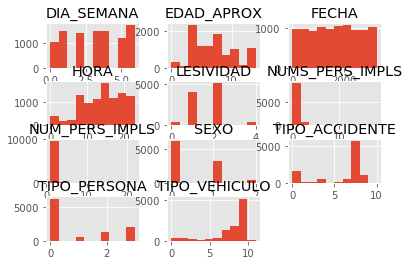

In [204]:
df_accs_lab_sample.drop(['DISTRITO'],1).hist()

plt.show()

In [205]:
df_accs_lab_sample.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX', 'NUMS_PERS_IMPLS'],
      dtype='object')

In [206]:
#Y también podemos interrelacionar las entradas de a pares
#sb.pairplot(df_accs_lab.dropna(), hue='DISTRITO',size=11,vars=['FECHA', 'HORA', 'DIA_SEMANA', 'NUM_PERS_IMPLS', \
#       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD', \
#       'EDAD_APROX', 'NUMS_PERS_IMPLS'],kind='reg')

/home/dsc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


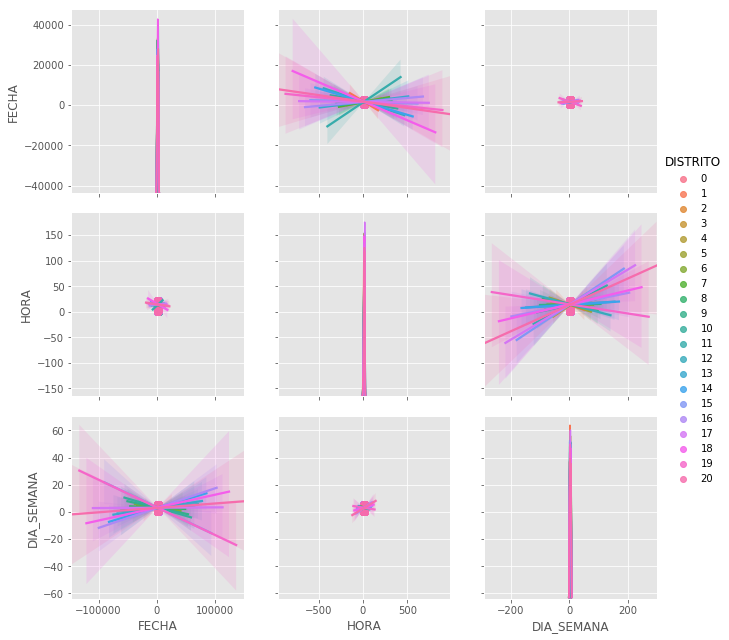

In [208]:
#Y también podemos interrelacionar las entradas de a pares
sb.pairplot(df_accs_lab_sample.dropna(), hue='DISTRITO',height=3,vars=['FECHA', 'HORA', 'DIA_SEMANA'],kind='reg')

/home/dsc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


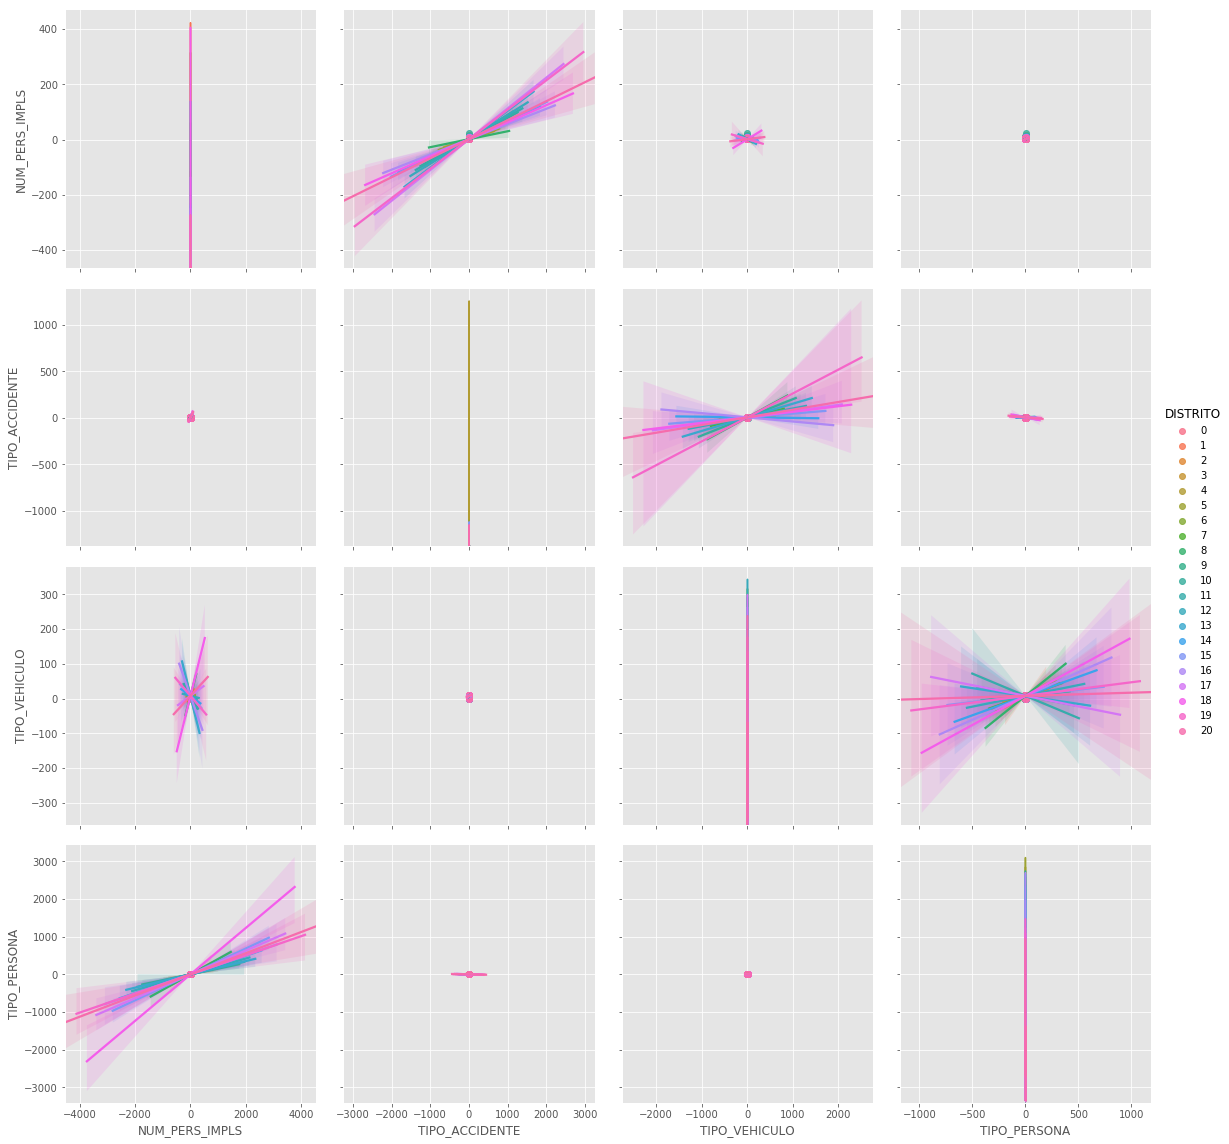

In [209]:
#Y también podemos interrelacionar las entradas de a pares
sb.pairplot(df_accs_lab_sample.dropna(), hue='DISTRITO',height=4,vars=['NUM_PERS_IMPLS', \
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA'],kind='reg')

/home/dsc/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


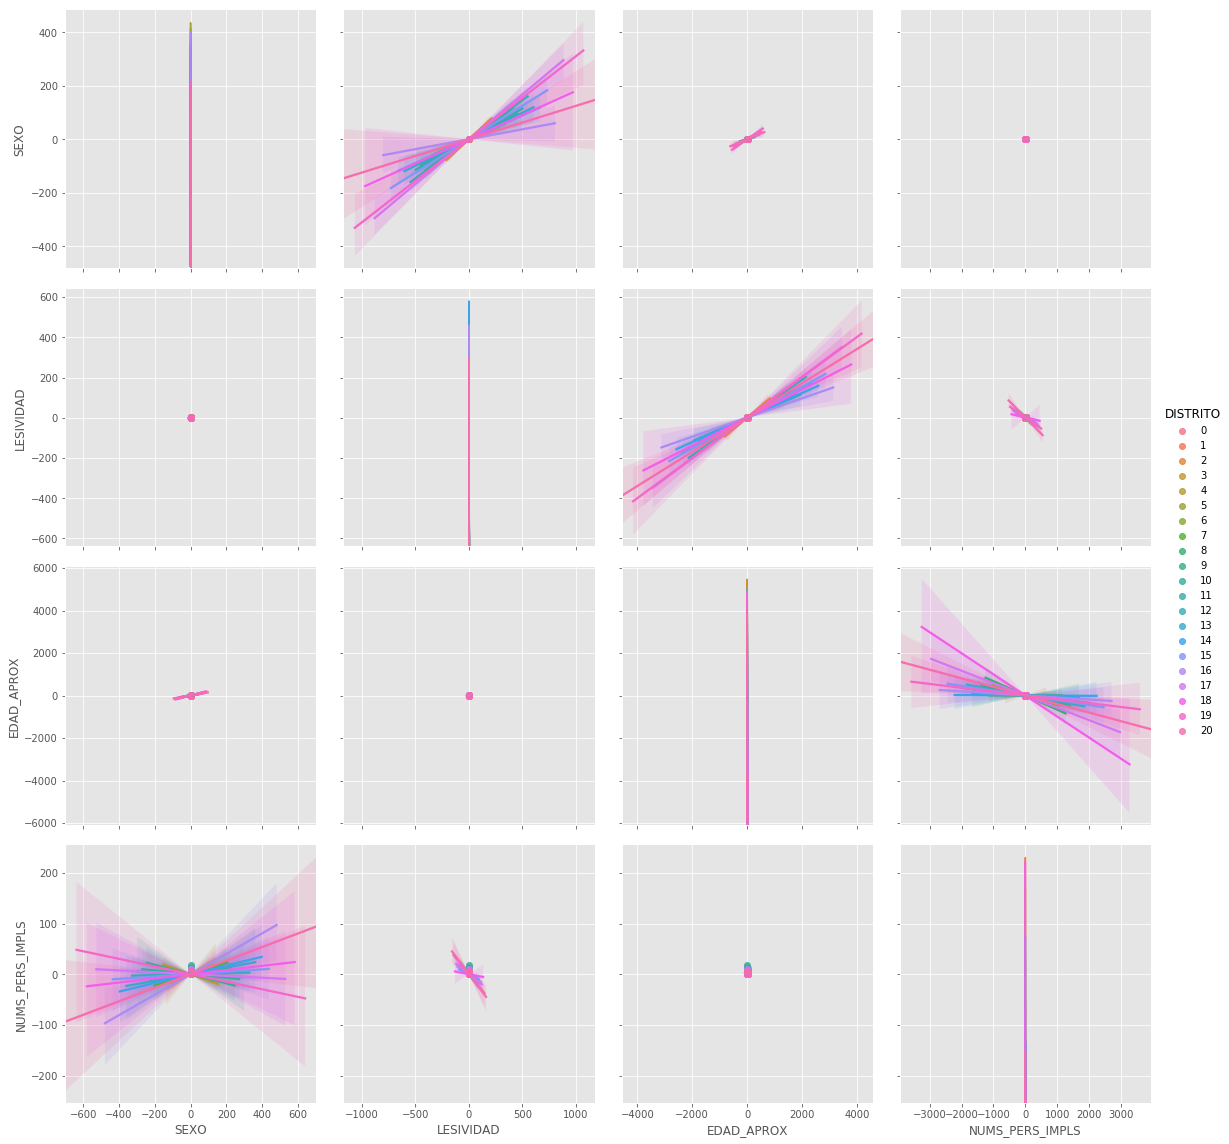

In [210]:
#Y también podemos interrelacionar las entradas de a pares
sb.pairplot(df_accs_lab_sample.dropna(), hue='DISTRITO',size=4,vars=['SEXO', 'LESIVIDAD', \
       'EDAD_APROX', 'NUMS_PERS_IMPLS'],kind='reg')

In [256]:
# Cargamos variables con datos de muestra
X = np.array(df_accs_lab_sample.drop(['DISTRITO'],1))
y = np.array(df_accs_lab_sample['DISTRITO'])
X.shape


(10000, 11)

### Regresión Logística con SKLearn

In [257]:
# Creamos el Modelo de Regresión Logística y 
# hacemos que se ajuste (fit) a nuestro conjunto de entradas X y salidas ‘y’.
model_LOGREG = linear_model.LogisticRegression()
model_LOGREG.fit(X,y)

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [261]:
# Clasificamos todo nuestro conjunto de entradas X utilizando el método «predict(X)» para el modelo
# y revisamos algunas de sus salidas para comprobar si coincide con las salidas reales de nuestro origen
predictions_LOGREG = model_LOGREG.predict(X)
print(predictions_LOGREG[0])

4


In [262]:
df_accs_lab['DISTRITO'][0]

4

In [263]:
type(predictions_LOGREG)

numpy.ndarray

In [264]:
predictions_LOGREG.dtype

dtype('int64')

In [265]:
predictions_LOGREG.shape

(10000,)

In [266]:
# Calidad de nuestro modelo, nos devuelve la precisión media de las predicciones
model_LOGREG.score(X,y)

0.0935

## VALIDAR MODELO

In [268]:
# Cargamos variables.
X = np.array(df_accs_lab.drop(['DISTRITO'],1))
y = np.array(df_accs_lab['DISTRITO'])
X.shape


(252998, 11)

In [269]:
# Train-test split
# Load the library
from sklearn.model_selection import train_test_split
# Create 2 groups each with input and labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [271]:
# Volvemos a compilar nuestro modelo de Regresión Logística pero esta vez sólo con 80% 
# de los datos de entrada y calculamos el nuevo scoring
name='Logistic Regression'
kfold = model_selection.KFold(n_splits=10)
cv_results = model_selection.cross_val_score(model_LOGREG, X_train, y_train, cv=kfold, scoring='accuracy')
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: 

Logistic Regression: 0.090752 (0.001275)


In [272]:
# Y ahora hacemos las predicciones (en realidad clasificación) utilizando nuestro «cross validation set»
# es decir del subconjunto que habíamos apartado. 
# Aciertos: xxx %
predictions_LOGREG = model_LOGREG.predict(X_test)
print(accuracy_score(y_test, predictions_LOGREG))

0.08806324110671937


# Resultados del modelo

In [273]:
## Matrix de confusión para los errores
print(confusion_matrix(y_test, predictions_LOGREG))

[[   0    0  105  500 1096    9    3   31    0    0   17    0  440   21
   299    0    1    0    0    0    0]
 [   0    0   37  172  252    1    0    7    0    0    1    0   93    2
    83    0    1    0    0    0    0]
 [   0    0  224  656 1091    4    2   28    0    0   17    0  744   25
   319    0    3    0    0    0    0]
 [   0    0  176 1160 1225   15    2   32    0    0   16    0  504   31
   493    0    4    0    0    0    0]
 [   0    0  166  798 1650   13    3   41    0    0   14    0  561   28
   480    0    3    0    0    0    0]
 [   0    0  137  765 1081    9    2   19    0    0   11    0  398   15
   419    0    4    0    0    0    0]
 [   0    0  187  637 1390   15    7   38    0    0   17    0  595   22
   400    0    4    0    0    0    0]
 [   0    0  158  513 1121    6    3   49    0    0    6    0  518   24
   265    0    2    0    0    0    0]
 [   0    0  100  344  676    7    3   33    0    0    7    0  341    4
   183    0    1    0    0    0    0]
 [   0    

In [275]:
## Informe de clasificación con nuestro conjunto de TEST
# Observamos el promedio de F1-score
print(classification_report(y_test, predictions_LOGREG))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2522
           1       0.00      0.00      0.00       649
           2       0.08      0.07      0.07      3113
           3       0.11      0.32      0.16      3658
           4       0.08      0.44      0.14      3757
           5       0.05      0.00      0.01      2860
           6       0.11      0.00      0.00      3312
           7       0.08      0.02      0.03      2665
           8       0.00      0.00      0.00      1699
           9       0.00      0.00      0.00      2401
          10       0.07      0.01      0.01      2750
          11       0.00      0.00      0.00      1284
          12       0.09      0.25      0.13      3223
          13       0.11      0.02      0.03      2778
          14       0.08      0.13      0.10      3769
          15       0.00      0.00      0.00      2432
          16       0.06      0.00      0.00      2718
          17       0.00    

/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/dsc/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Clasificación (o predicción) de nuevos valores

In [277]:
df_accs_lab.columns

Index(['FECHA', 'HORA', 'DIA_SEMANA', 'DISTRITO', 'NUM_PERS_IMPLS',
       'TIPO_ACCIDENTE', 'TIPO_VEHICULO', 'TIPO_PERSONA', 'SEXO', 'LESIVIDAD',
       'EDAD_APROX', 'NUMS_PERS_IMPLS'],
      dtype='object')

In [278]:
df_accs_lab.head(1)

,FECHA,HORA,DIA_SEMANA,DISTRITO,NUM_PERS_IMPLS,TIPO_ACCIDENTE,TIPO_VEHICULO,TIPO_PERSONA,SEXO,LESIVIDAD,EDAD_APROX,NUMS_PERS_IMPLS
0,0,0,6,4,1,7,9,0,0,2,3,0


In [ ]:
X_new = pd.DataFrame({'FECHA': [10], 'paginas': [3], 'acciones': [5], 'valor': [9]})
model_LOGREG.predict(X_new)